# Linear model of tuning curve emergence from connectome-weighted neural responses

In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from aux import loadmat_h5
from disp import set_font_size

TUNING_FILE = 'data/simple/ipi_freq_timecourses.npy'
CELL_FILE = 'data/christa/VLP_knownAUD_neurons_copiedFromFlyWireDatabase_20200617.xlsx'
# W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'
W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn_cleftFilt_20210603.mat'

FPS = 8.5

In [2]:
tuning_data = np.load(TUNING_FILE, allow_pickle=True)[0]

ipi = tuning_data['ipi']
ipi_rsps = tuning_data['ipi_rsps_means']

freq = tuning_data['freq']
freq_rsps = tuning_data['freq_rsps_means']

In [3]:
cell_df = pd.read_excel(CELL_FILE, engine='openpyxl')
cell_df[['short name', 'lineID for IPI/Freq tuning curves', 'Eckstein NT classification numeric']]

,short name,lineID for IPI/Freq tuning curves,Eckstein NT classification numeric
0,A1_L1,NaN,NaN
1,A1_L2,NaN,NaN
2,A1_L3,NaN,NaN
3,A1_R1,NaN,NaN
4,A1_R2,NaN,NaN
...,...,...,...
493,pC1as_R1,NaN,1.0
494,pC1as_R2,NaN,1.0
495,NaN,NaN,NaN
496,NaN,NaN,NaN


In [4]:
labels = np.array(cell_df['short name'])
line_ids = np.array(cell_df['lineID for IPI/Freq tuning curves'])  # floats/ints from 1 to 30 inclusive
signs = np.array(cell_df['Eckstein NT classification numeric'])

label2line = {label: line_id for label, line_id in zip(labels, line_ids)}
label2sign = {label: np.sign(sign) for label, sign in zip(labels, signs)}

In [5]:
w_th = 1

w_data = loadmat_h5(W_FILE)
labels_w = w_data['neuronNames'][:, 0]  # all labels with a row in the connectivity matrix

w_raw = w_data['cxns_noDup']
w = w_raw.copy()
w[w_raw < w_th] = 0
w[np.isnan(w)] = 0

# add sign
sign_mat = np.zeros(w.shape)  # note this zeroes any weights without signs attached
for cl, label in enumerate(labels_w):
    if label in label2sign and not np.isnan(label2sign[label]):
        sign_mat[cl, :] = label2sign[label]
            
w = w*sign_mat  # multiply w by signs

In [6]:
for label in labels_w:  # fill any missing labels with nan
    if label not in label2line:
        label2line[label] = np.nan

How to get tuning curves idx associated w/ row i in w:

1. Get i'th label from label_w.
2. Look up line in label2line. I.e. line = label2line[label_w[i]].

In [7]:
def get_ipi_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = ipi_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(ipi), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No ipi responses for cell {label}')
        return None

def get_freq_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = freq_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(freq), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No freq responses for cell {label}')
        return None

In [8]:
def w2rgba(w_, w_min=-3, w_max=3):
    cmap = cm.get_cmap('PiYG')
    return cmap(w_/6 + .5)

Model emergence of tuning curve from upstream tuning via linear dynamical system

$$\tau \frac{dr_i}{dt} = -r_i + \sum_j W_{ij} x_j$$

Each target neuron (col in weight matrix) w/ corresponding tuning curve dataset gives distinct analysis to do. We take the tuning curve data for the target neuron, look up its upstream neighbors and their weights onto the target neuron, compute a model response using a linear dynamical system and the upstream responses, then recompute the tuning curve for the model responses.

In [9]:
def get_tuning_error(tuning_true, tuning_model):
    tuning_true_z = tuning_true.copy()
    tuning_true_z -= tuning_true_z.mean()
    tuning_true_z /= tuning_true_z.std()
    
    tuning_model_z = tuning_model.copy()
    tuning_model_z -= tuning_model_z.mean()
    tuning_model_z /= tuning_model_z.std()
    
    return np.sqrt(np.nanmean((tuning_true_z - tuning_model_z)**2))

In [10]:
# IPI tuning
DT = 1/FPS
TAU = .5
INRNS = np.argsort((np.abs(w) > 0).sum(axis=0))[::-1]
INRNS_PLOT = []

labels_up_total_all = {}
labels_up_valid_all = {}
labels_up_missing_all = {}

rsp_err_all = {}
tuning_err_all = {}

tuning_curves_data_all = {}
tuning_curves_model_all = {}

labels_no_tuning = []
labels_no_upstream = []

w_up_e_total_all = {}
w_up_i_total_all = {}

w_up_e_valid_all = {}
w_up_i_valid_all = {}

n_skipped = 0

for inrn in INRNS:
    
    label = labels_w[inrn]
    
    t = np.arange(164)/FPS

    if np.isnan(label2line[label]):
        print(f'No IPI tuning data for cell {label}')
        labels_no_tuning.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
        
    # upstream inputs
    iup = w[:, inrn].nonzero()[0]  # idxs relative to w and labels_w
    w_up = w[iup, inrn]  # weights
    labels_up = labels_w[iup]  # labels
    lines_up = np.array([label2line[label_up] for label_up in labels_up])
    
    # subset of upstream inputs with tuning curve data (mask for previous 4 arrays)
    mvalid = ~np.isnan(lines_up)
    assert len(iup) == len(w_up) == len(labels_up) == len(lines_up)
    
    if np.sum(mvalid) == 0:
        print(f'No upstream IPI tuning data for cell {label}')
        labels_no_upstream.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
 
    labels_up_valid = labels_up[mvalid]  # labels of upstream cells w/ IPI data
    labels_up_missing = labels_up[~mvalid]  # labels of upstream cells w/o IPI data
 
    labels_up_total_all[label] = labels_up.copy()
    labels_up_valid_all[label] = labels_up_valid.copy()
    labels_up_missing_all[label] = labels_up_missing.copy()
    
    # weights corresponding to valid upstream labels
    w_up_valid = w_up[mvalid]
    
    w_up_e_total_all[label] = np.nansum(w_up[w_up > 0])
    w_up_i_total_all[label] = np.nansum(w_up[w_up < 0])
    w_up_e_valid_all[label] = np.nansum(w_up_valid[w_up_valid > 0])
    w_up_i_valid_all[label] = np.nansum(w_up_valid[w_up_valid < 0])
    
    w_scale = np.nanstd(w_up_valid) if len(w_up_valid) >= 2 else 1
    w_up_valid /= w_scale
    
    # target neuron's true ipi time courses
    rsps_data = get_ipi_timecourses(label)
    rsps_data /= np.nanstd(rsps_data)  # z-score across time & stims

    # upstream neuron ipi time courses
    rsps_up_all = [get_ipi_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each IPI
    rsps_model = np.nan * np.zeros((len(ipi), len(t)))  # one row per IPI
    for cipi, ipi_ in enumerate(ipi):
        # get array of upstream neuron activities for this IPI
        rsp_up = np.array([rsps_up[cipi, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        r[0] = 0

        for ct, t_ in enumerate(t[1:], 1):
            dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
            r[ct] = r[ct-1] + dr
        
        rsps_model[cipi, :] = r.copy()
        
    rsps_model /= np.nanstd(rsps_model)  # z-score across time & stims
    
    rsp_err_all[label] = np.sqrt(np.nanmean((rsps_model - rsps_data)**2))
    
    # compute IPI tuning curves for data and model
    mtuning = (5 <= t) & (t < 13)
    
    rsp_tavg_data = np.array([rsp_data[mtuning].sum()*DT for rsp_data in rsps_data])
    rsp_tavg_model = np.array([rsp_model[mtuning].sum()*DT for rsp_model in rsps_model])
    
    tuning_curves_data_all[label] = rsp_tavg_data.copy()
    tuning_curves_model_all[label] = rsp_tavg_model.copy()
    
    tuning_err_all[label] = np.sqrt(np.mean((rsp_tavg_data - rsp_tavg_model)**2))
       
    # input currents for each IPI and true vs modeled output current for each IPI
    if inrn not in INRNS_PLOT:
        continue
        
    fig = plt.figure(figsize=(17, 6), tight_layout=True)
    ax1 = fig.add_subplot(2, 6, 1)
    axs = np.array([
        [ax1] + [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(2, 6)] + [fig.add_subplot(2, 6, 6)],
        [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(7, 12)] + [fig.add_subplot(2, 6, 12)],
    ])

    for cipi, (ax, ipi_) in enumerate(zip(axs[0, :-1], ipi)):  # loop over IPIs
        # plot all upstream responses (i.e. inputs) colored by weight
        rsp_up = np.array([rsps_up[cipi, :] for rsps_up in rsps_up_all])  # upstream responses at this IPI
        assert len(rsp_up) == len(w_up_valid)

        for rsp_up_, w_ in zip(rsp_up, w_up_valid):
            ax.plot(t, rsp_up_, c=w2rgba(w_))

        ax.set_facecolor((.8, .8, .8))
        ax.set_title(f'{inrn}: {label}\n{len(w_up)} upstream\n{len(labels_up_valid)} valid, {len(labels_up_missing)} missing \nIPI = {ipi_} ms')
    
    # true vs modeled target neuron response (for all IPIs)
    for cipi, (ax, ipi_) in enumerate(zip(axs[1, :-1], ipi)):
        ax.plot(t, rsps_data[cipi], c='k')
        ax.plot(t, rsps_model[cipi], c='b')

        ax.set_xlabel('Time (s)')
        
    axs[1, 0].legend(['Data', 'Model'])

    axs[0, -1].scatter(lines_up[mvalid], w_up[mvalid], c=[w2rgba(w_/w_scale) for w_ in w_up[mvalid]])
    axs[0, -1].scatter(np.repeat(35, (~mvalid).sum()), w_up[~mvalid], facecolors='none', edgecolors=[w2rgba(w_/w_scale) for w_ in w_up[~mvalid]])
    axs[0, -1].set_facecolor((.8, .8, .8))
    axs[0, -1].axhline(0, color='gray', ls='--')
    axs[0, -1].axvline(label2line[label], c='k')
    axs[0, -1].set_xlim(0, 36)
    axs[0, -1].grid()

    axs[0, -1].set_xlabel('Line')
    axs[0, -1].set_ylabel('Weight')
    axs[0, -1].set_title(f'Targ line:{int(round(label2line[label]))}\nInput lines:\n{sorted(np.unique([int(line_up) for line_up in lines_up if not np.isnan(line_up)]))}')
    
    axs[1, -1].plot(ipi, rsp_tavg_data, c='k')
    axs[1, -1].plot(ipi, rsp_tavg_model, c='b')
    axs[1, -1].axhline(0, color='gray', ls='--')
    axs[1, -1].set_xlabel('IPI (ms)')
    axs[1, -1].set_ylabel('Integral')
    axs[1, -1].set_title('Tuning curves')

No IPI tuning data for cell WV-WV-1_3
No IPI tuning data for cell WV-WV-1_1
No IPI tuning data for cell WV-WV-2_5
No IPI tuning data for cell WV-WV-2_4
No IPI tuning data for cell WV-WV-2_2
No IPI tuning data for cell WV-WV-2_6
No IPI tuning data for cell WV-WV-3_6
No IPI tuning data for cell WV-WV-1_2
No IPI tuning data for cell WV-WV-3_7
No IPI tuning data for cell WV-WV-2_3
No IPI tuning data for cell WV-WV-2_1
No IPI tuning data for cell pC1al_L
No IPI tuning data for cell pC2lb_L1
No IPI tuning data for cell pMN1_L
No IPI tuning data for cell vpoEN_R1
No IPI tuning data for cell pC2lb_L2
No IPI tuning data for cell A1_R1
No IPI tuning data for cell pC2lb_R2
No IPI tuning data for cell pC2lb_R1
No IPI tuning data for cell vpoEN_L2
No IPI tuning data for cell vpoEN_L1
No IPI tuning data for cell GF_R
No IPI tuning data for cell vpoEN_R2
No IPI tuning data for cell pC1al_R
No IPI tuning data for cell WV-WV-3_2
No IPI tuning data for cell pMN2_L
No IPI tuning data for cell pC1as_L
No 

306 valid tuning curve analyses
187 skipped


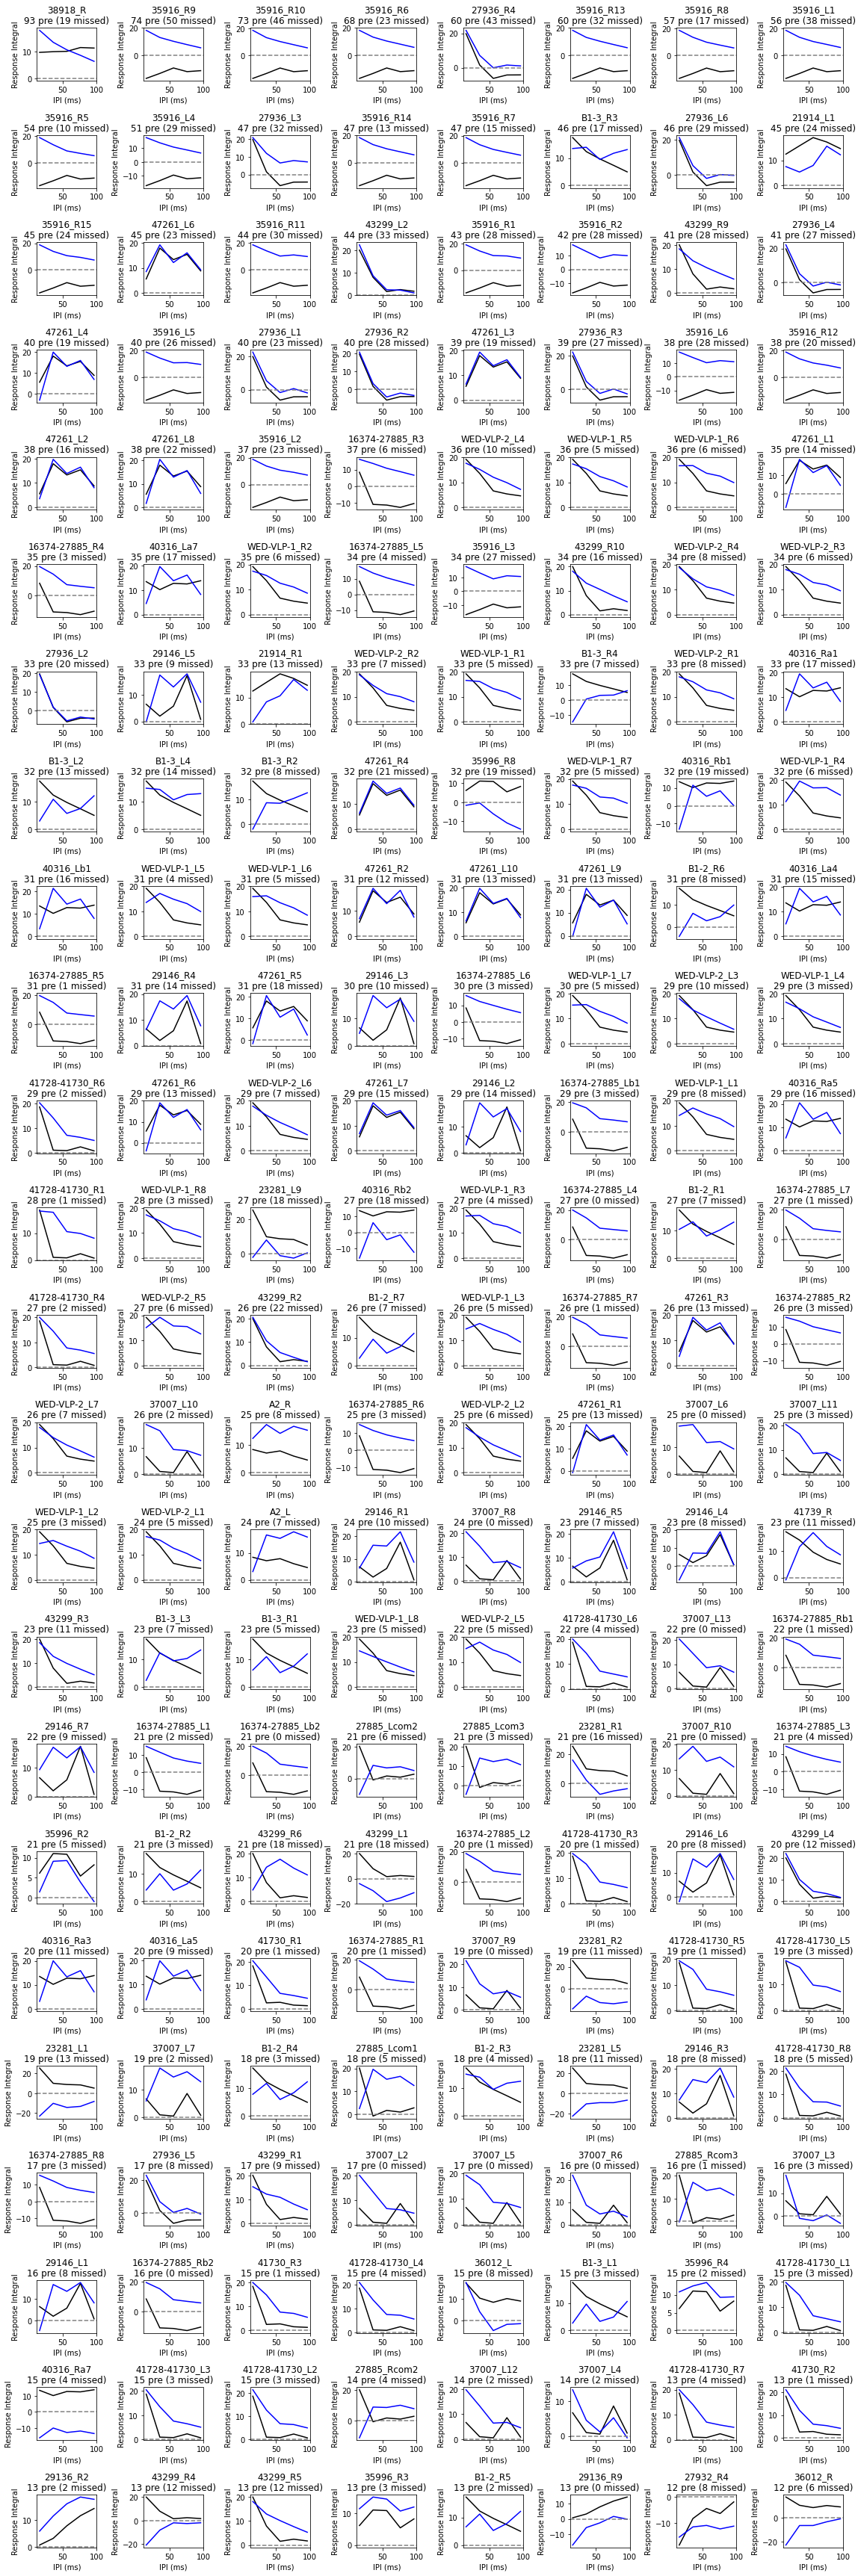

In [11]:
print(f'{len(tuning_curves_model_all)} valid tuning curve analyses')
print(f'{n_skipped} skipped')
fig, axs = plt.subplots(24, 8, figsize=(16, 48), tight_layout=True)
keys = list(tuning_curves_model_all.keys())

tuning_by_cell_dict = {key: {} for key in keys}

ipi_tuning_data_all = []
ipi_tuning_model_all = []

for ckey, key in enumerate(keys):
# for key, ax in zip(keys, axs.flatten()):
    tuning_data = tuning_curves_data_all[key]
    tuning_model = tuning_curves_model_all[key]
    
    ipi_tuning_data_all.append(tuning_data.copy())
    ipi_tuning_model_all.append(tuning_model.copy())
    
    if ckey < len(axs.flatten()):
        ax = axs.flatten()[ckey]
        ax.plot(ipi, tuning_data, c='k')
        ax.plot(ipi, tuning_model, c='b')
        ax.axhline(0, ls='--', color='gray')

        ax.set_xlabel('IPI (ms)')
        ax.set_ylabel('Response Integral')

        ax.set_title(f'{key}\n{len(labels_up_total_all[key])} pre ({len(labels_up_missing_all[key])} missed)')
    
for key in keys:
    tuning_data = tuning_curves_data_all[key]
    tuning_model = tuning_curves_model_all[key]
    
    tuning_by_cell_dict[key]['PRESYNAPTIC_TOTAL'] = len(labels_up_total_all[key])
    tuning_by_cell_dict[key]['PRESYNAPTIC_MISSING'] = len(labels_up_missing_all[key])
    tuning_by_cell_dict[key]['IPI_TUNING_ERROR_RMS'] = get_tuning_error(tuning_data, tuning_model)  #np.sqrt(np.mean((tuning_data - tuning_model)**2))
    tuning_by_cell_dict[key]['W_PRE_E_TOTAL'] = w_up_e_total_all[key]
    tuning_by_cell_dict[key]['W_PRE_I_TOTAL'] = w_up_i_total_all[key]
    tuning_by_cell_dict[key]['W_PRE_E_MISSING'] = w_up_e_total_all[key] - w_up_e_valid_all[key]
    tuning_by_cell_dict[key]['W_PRE_I_MISSING'] = w_up_i_total_all[key] - w_up_i_valid_all[key]
    
    for ipi_, data_response in zip(ipi, tuning_data):
        tuning_by_cell_dict[key][f'DATA_RESPONSE_IPI_{ipi_}_MS'] = data_response
    for ipi_, model_response in zip(ipi, tuning_model):
        tuning_by_cell_dict[key][f'MODEL_RESPONSE_IPI_{ipi_}_MS'] = data_response
    
fig.savefig('plots/ipi_tuning_all.pdf')

ipi_tuning_data_all = np.array(ipi_tuning_data_all)
ipi_tuning_model_all = np.array(ipi_tuning_model_all)

In [12]:
# Sine freq tuning
DT = 1/FPS
TAU = .5
INRNS = np.argsort((np.abs(w) > 0).sum(axis=0))[::-1]
INRNS_PLOT = []

labels_up_total_all = {}
labels_up_valid_all = {}
labels_up_missing_all = {}

rsp_err_all = {}
tuning_err_all = {}

tuning_curves_data_all = {}
tuning_curves_model_all = {}

labels_no_tuning = []
labels_no_upstream = []

n_skipped = 0

for inrn in INRNS:
    
    label = labels_w[inrn]
    
    t = np.arange(164)/FPS

    if np.isnan(label2line[label]):
        print(f'No FREQ tuning data for cell {label}')
        labels_no_tuning.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
        
    # upstream inputs
    iup = w[:, inrn].nonzero()[0]  # idxs relative to w and labels_w
    w_up = w[iup, inrn]  # weights
    labels_up = labels_w[iup]  # labels
    lines_up = np.array([label2line[label_up] for label_up in labels_up])
    
    # subset of upstream inputs with tuning curve data (mask for previous 4 arrays)
    mvalid = ~np.isnan(lines_up)
    assert len(iup) == len(w_up) == len(labels_up) == len(lines_up)
    
    if np.sum(mvalid) == 0:
        print(f'No upstream FREQ tuning data for cell {label}')
        labels_no_upstream.append(label)
        rsp_err_all[label] = np.nan
        tuning_err_all[label] = np.nan
        n_skipped += 1
        continue
 
    labels_up_valid = labels_up[mvalid]  # labels of upstream cells w/ FREQ data
    labels_up_missing = labels_up[~mvalid]  # labels of upstream cells w/o FREQ data
 
    labels_up_total_all[label] = labels_up.copy()
    labels_up_valid_all[label] = labels_up_valid.copy()
    labels_up_missing_all[label] = labels_up_missing.copy()
    
    # weights corresponding to valid upstream labels
    w_up_valid = w_up[mvalid]
    w_scale = np.nanstd(w_up_valid) if len(w_up_valid) >= 2 else 1
    w_up_valid /= w_scale
    
    # target neuron's true freq time courses
    rsps_data = get_freq_timecourses(label)
    rsps_data /= np.nanstd(rsps_data)  # z-score across time & stims

    # upstream neuron freq time courses
    rsps_up_all = [get_freq_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each FREQ
    rsps_model = np.nan * np.zeros((len(freq), len(t)))  # one row per FREQ
    for cfreq, freq_ in enumerate(freq):
        # get array of upstream neuron activities for this FREQ
        rsp_up = np.array([rsps_up[cfreq, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        r[0] = 0

        for ct, t_ in enumerate(t[1:], 1):
            dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
            r[ct] = r[ct-1] + dr
        
        rsps_model[cfreq, :] = r.copy()
        
    rsps_model /= np.nanstd(rsps_model)  # z-score across time & stims
    
    rsp_err_all[label] = np.sqrt(np.nanmean((rsps_model - rsps_data)**2))
    
    # compute freq tuning curves for data and model
    mtuning = (5 <= t) & (t < 13)
    
    rsp_tavg_data = np.array([rsp_data[mtuning].sum()*DT for rsp_data in rsps_data])
    rsp_tavg_model = np.array([rsp_model[mtuning].sum()*DT for rsp_model in rsps_model])
    
    tuning_curves_data_all[label] = rsp_tavg_data.copy()
    tuning_curves_model_all[label] = rsp_tavg_model.copy()
       
    tuning_err_all[label] = np.sqrt(np.mean((rsp_tavg_data - rsp_tavg_model)**2))
    
    # input currents for each freq and true vs modeled output current for each freq
    if inrn not in INRNS_PLOT:
        continue
        
    fig = plt.figure(figsize=(17, 6), tight_layout=True)
    ax1 = fig.add_subplot(2, 6, 1)
    axs = np.array([
        [ax1] + [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(2, 6)] + [fig.add_subplot(2, 6, 6)],
        [fig.add_subplot(2, 6, i, sharex=ax1, sharey=ax1) for i in range(7, 12)] + [fig.add_subplot(2, 6, 12)],
    ])

    for cfreq, (ax, freq_) in enumerate(zip(axs[0, :-1], freq)):  # loop over freqs
        # plot all upstream responses (i.e. inputs) colored by weight
        rsp_up = np.array([rsps_up[cfreq, :] for rsps_up in rsps_up_all])  # upstream responses at this freq
        assert len(rsp_up) == len(w_up_valid)

        for rsp_up_, w_ in zip(rsp_up, w_up_valid):
            ax.plot(t, rsp_up_, c=w2rgba(w_))

        ax.set_facecolor((.8, .8, .8))
        ax.set_title(f'{inrn}: {label}\n{len(w_up)} upstream\n{len(labels_up_valid)} valid, {len(labels_up_missing)} missing \nfreq = {freq_} Hz')
    
    # true vs modeled target neuron response (for all freqs)
    for cfreq, (ax, freq_) in enumerate(zip(axs[1, :-1], freq)):
        ax.plot(t, rsps_data[cfreq], c='k')
        ax.plot(t, rsps_model[cfreq], c='b')

        ax.set_xlabel('Time (s)')
        
    axs[1, 0].legend(['Data', 'Model'])

    axs[0, -1].scatter(lines_up[mvalid], w_up[mvalid], c=[w2rgba(w_/w_scale) for w_ in w_up[mvalid]])
    axs[0, -1].scatter(np.repeat(35, (~mvalid).sum()), w_up[~mvalid], facecolors='none', edgecolors=[w2rgba(w_/w_scale) for w_ in w_up[~mvalid]])
    axs[0, -1].set_facecolor((.8, .8, .8))
    axs[0, -1].axhline(0, color='gray', ls='--')
    axs[0, -1].axvline(label2line[label], c='k')
    axs[0, -1].set_xlim(0, 36)
    axs[0, -1].grid()

    axs[0, -1].set_xlabel('Line')
    axs[0, -1].set_ylabel('Weight')
    axs[0, -1].set_title(f'Targ line: {int(round(label2line[label]))}\nInput lines:\n{sorted(np.unique([int(line_up) for line_up in lines_up if not np.isnan(line_up)]))}')
    
    axs[1, -1].plot(freq, rsp_tavg_data, c='k')
    axs[1, -1].plot(freq, rsp_tavg_model, c='b')
    axs[1, -1].axhline(0, color='gray', ls='--')
    axs[1, -1].set_xlabel('Freq (Hz)')
    axs[1, -1].set_ylabel('Integral')
    axs[1, -1].set_title('Tuning curves')

No FREQ tuning data for cell WV-WV-1_3
No FREQ tuning data for cell WV-WV-1_1
No FREQ tuning data for cell WV-WV-2_5
No FREQ tuning data for cell WV-WV-2_4
No FREQ tuning data for cell WV-WV-2_2
No FREQ tuning data for cell WV-WV-2_6
No FREQ tuning data for cell WV-WV-3_6
No FREQ tuning data for cell WV-WV-1_2
No FREQ tuning data for cell WV-WV-3_7
No FREQ tuning data for cell WV-WV-2_3
No FREQ tuning data for cell WV-WV-2_1
No FREQ tuning data for cell pC1al_L
No FREQ tuning data for cell pC2lb_L1
No FREQ tuning data for cell pMN1_L
No FREQ tuning data for cell vpoEN_R1
No FREQ tuning data for cell pC2lb_L2
No FREQ tuning data for cell A1_R1
No FREQ tuning data for cell pC2lb_R2
No FREQ tuning data for cell pC2lb_R1
No FREQ tuning data for cell vpoEN_L2
No FREQ tuning data for cell vpoEN_L1
No FREQ tuning data for cell GF_R
No FREQ tuning data for cell vpoEN_R2
No FREQ tuning data for cell pC1al_R
No FREQ tuning data for cell WV-WV-3_2
No FREQ tuning data for cell pMN2_L
No FREQ tunin

306 valid tuning curve analyses
187 skipped


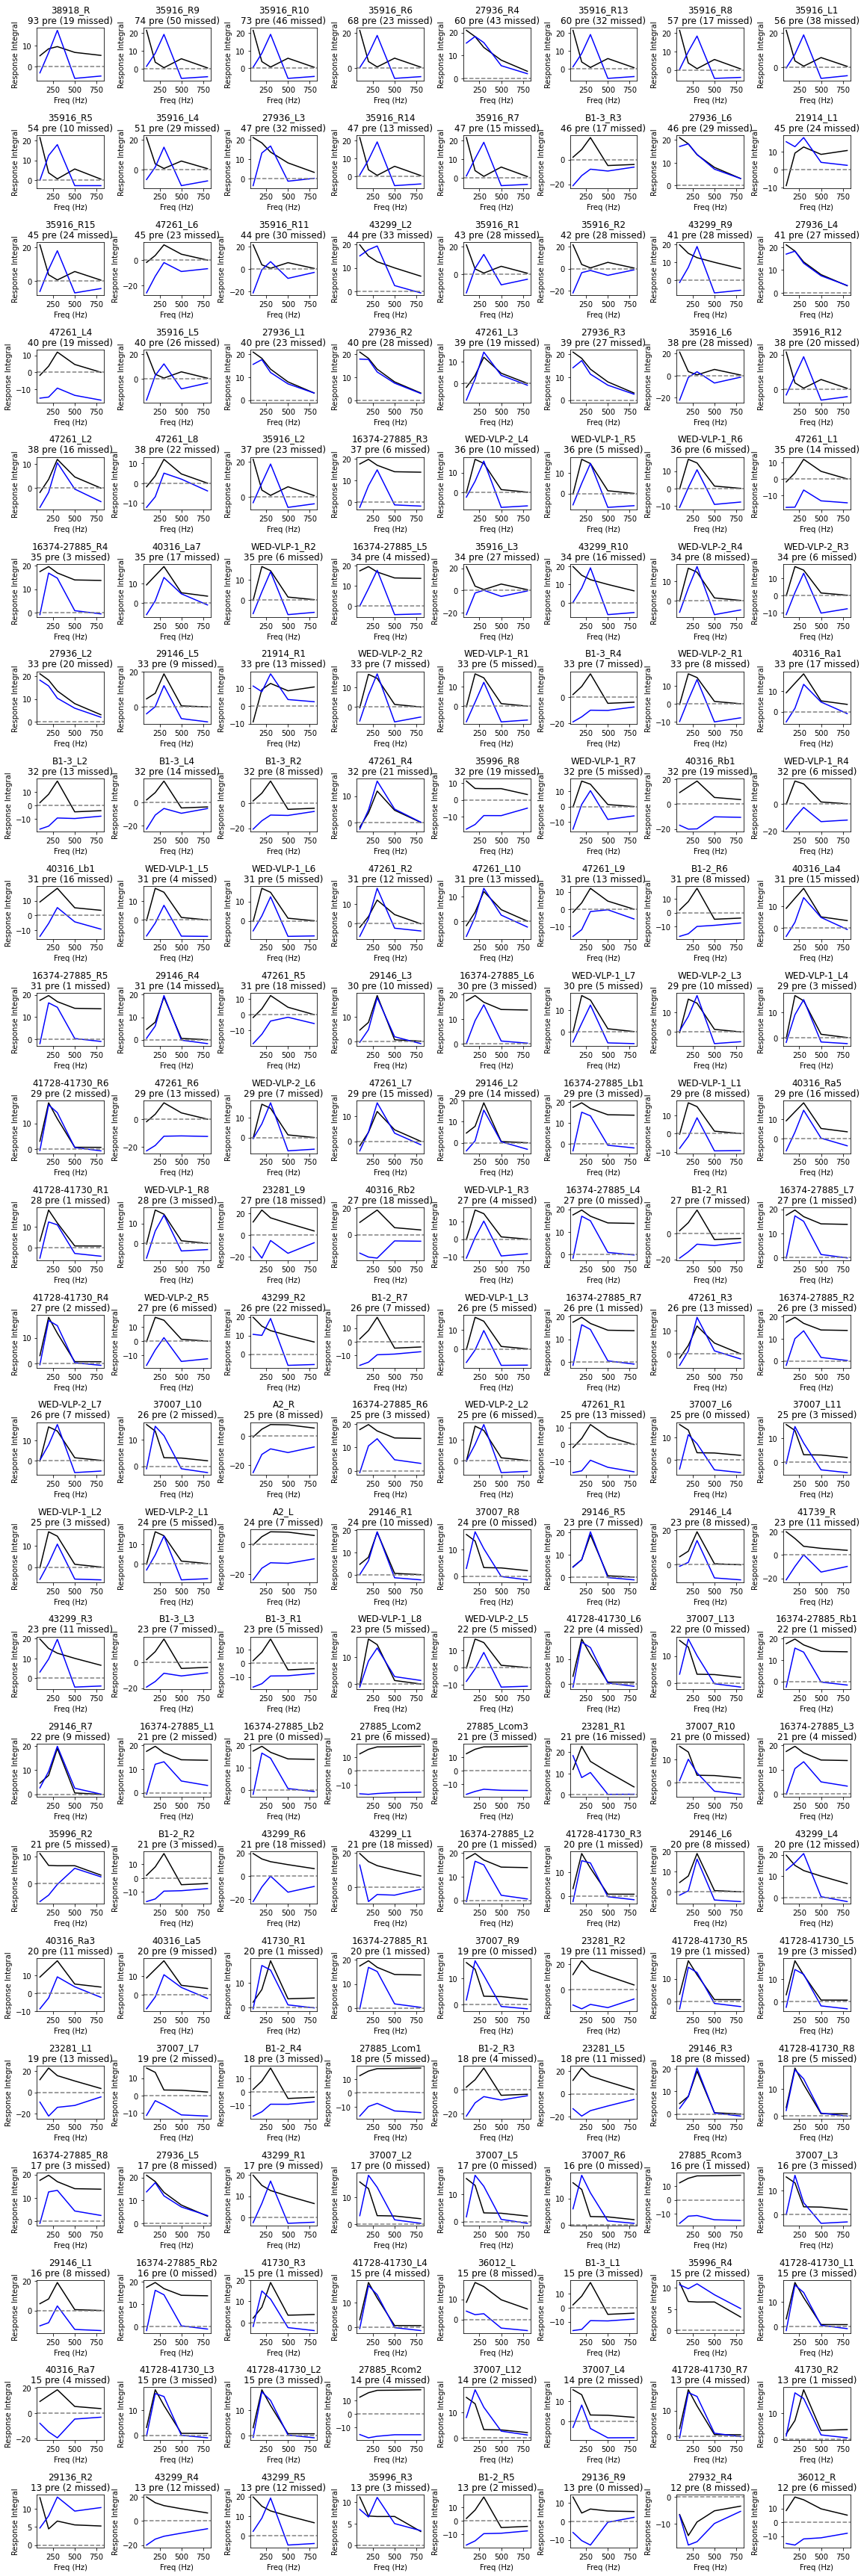

In [13]:
print(f'{len(tuning_curves_model_all)} valid tuning curve analyses')
print(f'{n_skipped} skipped')
fig, axs = plt.subplots(24, 8, figsize=(16, 48), tight_layout=True)
keys = list(tuning_curves_model_all.keys())

freq_tuning_data_all = []
freq_tuning_model_all = []

for ckey, key in enumerate(keys):
# for key, ax in zip(keys, axs.flatten()):
    tuning_data = tuning_curves_data_all[key]
    tuning_model = tuning_curves_model_all[key]
    
    freq_tuning_data_all.append(tuning_data.copy())
    freq_tuning_model_all.append(tuning_model.copy())
    
    if ckey < len(axs.flatten()):
        ax = axs.flatten()[ckey]
    
        ax.plot(freq, tuning_data, c='k')
        ax.plot(freq, tuning_model, c='b')
        ax.axhline(0, ls='--', color='gray')

        ax.set_xlabel('Freq (Hz)')
        ax.set_ylabel('Response Integral')

        ax.set_title(f'{key}\n{len(labels_up_total_all[key])} pre ({len(labels_up_missing_all[key])} missed)')
    
for key in keys:
    tuning_data = tuning_curves_data_all[key]
    tuning_model = tuning_curves_model_all[key]
    
    tuning_by_cell_dict[key]['FREQ_TUNING_ERROR_RMS'] = get_tuning_error(tuning_data, tuning_model)  #np.sqrt(np.mean((tuning_data - tuning_model)**2))
    
    for freq_, data_response in zip(freq, tuning_data):
        tuning_by_cell_dict[key][f'DATA_RESPONSE_FREQ_{freq_}_HZ'] = data_response
    for freq_, model_response in zip(freq, tuning_model):
        tuning_by_cell_dict[key][f'MODEL_RESPONSE_FREQ_{freq_}_HZ'] = data_response
    

freq_tuning_data_all = np.array(freq_tuning_data_all)
freq_tuning_model_all = np.array(freq_tuning_model_all)
    
fig.savefig('plots/sine_freq_tuning_all.pdf')

In [27]:
freq_tuning_errs

array([0.45225191, 1.57069119, 1.58589627, 1.58627776, 0.39643397,
       1.57744914, 1.607036  , 1.5990542 , 1.646864  , 1.66340497,
       1.24734888, 1.59139913, 1.60258779, 1.40636567, 0.21696548,
       1.61457721, 1.72510439, 0.71627411, 1.95936197, 0.70507276,
       1.85271895, 1.99950911, 1.20546907, 0.20996482, 0.3237473 ,
       1.90134622, 0.25494853, 0.12380096, 0.18669507, 0.32079531,
       1.98859272, 1.67484207, 0.08127325, 0.53857085, 1.68211806,
       0.99655157, 0.52906776, 0.4726903 , 0.51227849, 0.48253371,
       0.76594138, 0.90682456, 0.4827003 , 0.86638198, 1.9991153 ,
       1.16898156, 0.48010864, 0.50428203, 0.07256913, 0.07115231,
       1.475352  , 0.46849916, 0.50813098, 1.50461599, 0.50077132,
       0.8664559 , 1.4906741 , 1.29212408, 1.47582116, 0.06417145,
       1.95028738, 0.52644331, 1.96156046, 0.69832565, 0.82193656,
       0.56449637, 0.53009563, 0.32575415, 0.08123569, 0.80204376,
       1.56693673, 0.81314172, 0.79167028, 0.16342839, 0.89674

In [14]:
import sys
# true mean tuning errors
# def get_tuning_error(tuning_true, tuning_model):
#     return np.sqrt(np.nanmean((tuning_true - tuning_model)**2))

# ipi_tuning_errs = np.sqrt(np.nanmean((ipi_tuning_data_all - ipi_tuning_model_all)**2, axis=1))
# freq_tuning_errs = np.sqrt(np.nanmean((freq_tuning_data_all - freq_tuning_model_all)**2, axis=1))
ipi_tuning_errs = np.array([get_tuning_error(ipi_tuning_data, ipi_tuning_model) for ipi_tuning_data, ipi_tuning_model in zip(ipi_tuning_data_all, ipi_tuning_model_all)])
freq_tuning_errs = np.array([get_tuning_error(freq_tuning_data, freq_tuning_model) for freq_tuning_data, freq_tuning_model in zip(freq_tuning_data_all, freq_tuning_model_all)])

mean_ipi_tuning_err = np.nanmean(ipi_tuning_errs)
mean_freq_tuning_err = np.nanmean(freq_tuning_errs)

In [15]:
# shuffled mean tuning errors
N_SHUFFLE = 10000
ipi_tuning_errs_shuffled_all = []
freq_tuning_errs_shuffled_all = []

mean_ipi_tuning_errs_shuffled = []
mean_freq_tuning_errs_shuffled = []

for cshuffle in range(N_SHUFFLE):
    if cshuffle % 100 == 0:
        sys.stdout.write(f'{cshuffle} ')
    ipi_tuning_model_all_shuffle = ipi_tuning_model_all[np.random.permutation(len(ipi_tuning_model_all)), :]
    freq_tuning_model_all_shuffle = freq_tuning_model_all[np.random.permutation(len(freq_tuning_model_all)), :]
    
    ipi_tuning_errs_shuffled = np.array([
        get_tuning_error(ipi_tuning_data, ipi_tuning_model_shuffle) for ipi_tuning_data, ipi_tuning_model_shuffle in zip(ipi_tuning_data_all, ipi_tuning_model_all_shuffle)       
    ])
    freq_tuning_errs_shuffled = np.array([
        get_tuning_error(freq_tuning_data, freq_tuning_model_shuffle) for freq_tuning_data, freq_tuning_model_shuffle in zip(freq_tuning_data_all, freq_tuning_model_all_shuffle)       
    ])
#     ipi_tuning_errs_shuffled = np.sqrt(np.nanmean((ipi_tuning_data_all - ipi_tuning_model_all_shuffle)**2, axis=1))
#     freq_tuning_errs_shuffled = np.sqrt(np.nanmean((freq_tuning_data_all - freq_tuning_model_all_shuffle)**2, axis=1))
    
    ipi_tuning_errs_shuffled_all.extend(ipi_tuning_errs_shuffled)
    freq_tuning_errs_shuffled_all.extend(freq_tuning_errs_shuffled)
    
    mean_ipi_tuning_errs_shuffled.append(np.nanmean(ipi_tuning_errs_shuffled))
    mean_freq_tuning_errs_shuffled.append(np.nanmean(freq_tuning_errs_shuffled))

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 

P(ipi mean) < 0.0001
P(freq mean) < 0.0001


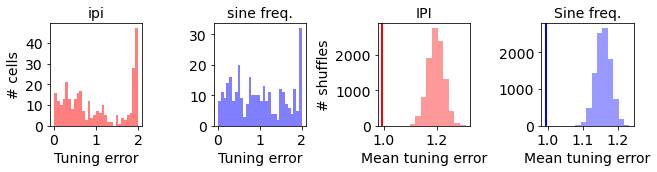

In [29]:
from scipy import stats

fig, axs = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)

bins = np.linspace(0, 2.5, 31)
binc = .5*(bins[:-1] + bins[1:])

axs[0].hist(ipi_tuning_errs, color='r', alpha=.5, bins=30)
axs[0].set_ylabel('# rois')
axs[0].set_title('ipi')
axs[1].hist(freq_tuning_errs, color='b', alpha=.5, bins=30)
axs[1].set_title('sine freq.')

cts_ipi_err_shuffled = np.histogram(ipi_tuning_errs_shuffled_all, bins=bins, density=True)[0]
cts_freq_err_shuffled = np.histogram(freq_tuning_errs_shuffled_all, bins=bins, density=True)[0]

# axs[0].plot(binc, cts_ipi_err_shuffled, color='r', lw=3)
axs[0].set_ylabel('# cells')
axs[0].set_title('ipi')
# axs[1].plot(binc, cts_freq_err_shuffled, color='b', lw=3)
axs[1].set_title('sine freq.')

for ax in axs[:2]:
    ax.set_xlabel('Tuning error')

axs[2].hist(mean_ipi_tuning_errs_shuffled, color='r', alpha=.4)
axs[2].axvline(mean_ipi_tuning_err, color='r', lw=2)
axs[2].set_ylabel('# shuffles')
# axs[2].set_xticks([10, 11, 12])
axs[2].set_title('IPI')

axs[3].hist(mean_freq_tuning_errs_shuffled, color='b', alpha=.4)
axs[3].axvline(mean_freq_tuning_err, color='b', lw=2)
# axs[3].set_xticks([11.5, 12.5, 13.5])
axs[3].set_title('Sine freq.')

for ax in axs[2:]:
#     ax.set_yticks([0, 1000, 2000, 3000])
#     ax.set_yticklabels(['0', '1k', '2k', '3k'])
    ax.set_xlabel('Mean tuning error')

set_font_size(axs, 14)

p_ipi = stats.ttest_ind(ipi_tuning_errs, ipi_tuning_errs_shuffled_all)[1]
p_freq = stats.ttest_ind(freq_tuning_errs, freq_tuning_errs_shuffled_all)[1]

# print('P(ipi) =', p_ipi)
# print('P(freq) =', p_freq)

print('P(ipi mean) <', np.max([np.mean(mean_ipi_tuning_err > mean_ipi_tuning_errs_shuffled), 1/N_SHUFFLE]) )
print('P(freq mean) <', np.max([np.mean(mean_freq_tuning_err > mean_freq_tuning_errs_shuffled), 1/N_SHUFFLE]) )

fig.savefig('plots/cb_ms/stats1.svg')

In [17]:
len(freq_tuning_errs)

306

In [19]:
columns_tuning_by_cell = ['CELL_NAME', 'IPI_TUNING_ERROR_RMS', 'FREQ_TUNING_ERROR_RMS', 'PRESYNAPTIC_TOTAL', 'PRESYNAPTIC_MISSING'] \
    + [f'W_PRE_E_TOTAL', f'W_PRE_I_TOTAL', f'W_PRE_E_MISSING', f'W_PRE_I_MISSING'] \
    + [f'DATA_RESPONSE_IPI_{ipi_}_MS' for ipi_ in ipi] + [f'MODEL_RESPONSE_IPI_{ipi_}_MS' for ipi_ in ipi] \
    + [f'DATA_RESPONSE_FREQ_{freq_}_HZ' for freq_ in freq] + [f'MODEL_RESPONSE_FREQ_{freq_}_HZ' for freq_ in freq]

data_dicts = []

for cell_name, cell_dict in tuning_by_cell_dict.items():
    cell_dict['CELL_NAME'] = cell_name
    data_dicts.append(cell_dict)
    
df_tuning_by_cell = pd.DataFrame(columns=columns_tuning_by_cell, data=data_dicts)

In [21]:
df_tuning_by_cell.to_csv('plots/cb_ms/cell_tuning_model_table.csv')

In [22]:
def test_corr_coef(x, y):
    mvalid = (~np.isnan(x)) & (~np.isnan(y))
    print(stats.linregress(x[mvalid], y[mvalid]))

test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_TOTAL'], df_tuning_by_cell['IPI_TUNING_ERROR_RMS'])
test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_TOTAL'], df_tuning_by_cell['FREQ_TUNING_ERROR_RMS'])

test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_MISSING'], df_tuning_by_cell['IPI_TUNING_ERROR_RMS'])
test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_MISSING'], df_tuning_by_cell['FREQ_TUNING_ERROR_RMS'])

test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_MISSING']/df_tuning_by_cell['PRESYNAPTIC_TOTAL'], df_tuning_by_cell['IPI_TUNING_ERROR_RMS'])
test_corr_coef(df_tuning_by_cell['PRESYNAPTIC_MISSING']/df_tuning_by_cell['PRESYNAPTIC_TOTAL'], df_tuning_by_cell['FREQ_TUNING_ERROR_RMS'])

LinregressResult(slope=0.0021884225941805487, intercept=0.9478293491674189, rvalue=0.04580960412808926, pvalue=0.428433048702459, stderr=0.002759833553756647)
LinregressResult(slope=-0.003509477917876658, intercept=1.0657002588247129, rvalue=-0.08332110675056373, pvalue=0.1492851344162345, stderr=0.0024273874831481374)
LinregressResult(slope=0.006805594848010261, intercept=0.9437993631447512, rvalue=0.08695297693433338, pvalue=0.13228473431287455, stderr=0.004509184362939934)
LinregressResult(slope=0.004536459892787765, intercept=0.9603151501489219, rvalue=0.06573892634337071, pvalue=0.25553302646666254, stderr=0.003982157344690052)
LinregressResult(slope=0.2529758871420909, intercept=0.9198198633346427, rvalue=0.08797911249137137, pvalue=0.12776265422263097, stderr=0.1656443503913332)
LinregressResult(slope=0.2579347919227861, intercept=0.9184731223915038, rvalue=0.10174136095325091, pvalue=0.07800543675925421, stderr=0.14585365540244113)


In [23]:
err_dict = {
    'IPI tuning error': df_tuning_by_cell['IPI_TUNING_ERROR_RMS'],
    'Sine freq tuning error': df_tuning_by_cell['FREQ_TUNING_ERROR_RMS'],
}


factor_dict = {}

pre_total = df_tuning_by_cell['PRESYNAPTIC_TOTAL']
pre_missing = df_tuning_by_cell['PRESYNAPTIC_MISSING']

w_pre_total = df_tuning_by_cell['W_PRE_E_TOTAL'] + np.abs(df_tuning_by_cell['W_PRE_I_TOTAL'])
w_pre_missing = df_tuning_by_cell['W_PRE_E_MISSING'] + np.abs(df_tuning_by_cell['W_PRE_I_MISSING'])

factor_dict['Total presynaptic'] = pre_total
factor_dict['Included presynaptic'] = pre_total - pre_missing
factor_dict['Missing presynaptic'] = pre_missing
factor_dict['Fraction missing\npresynaptic'] = pre_missing/pre_total
    
factor_dict['Total weighted\npresynaptic'] = w_pre_total
factor_dict['Included weighted\npresynaptic'] = w_pre_total - w_pre_missing
factor_dict['Missing weighted\npresynaptic'] = w_pre_missing
factor_dict['Fraction missing\nweighted presynaptic'] = w_pre_missing/pre_total

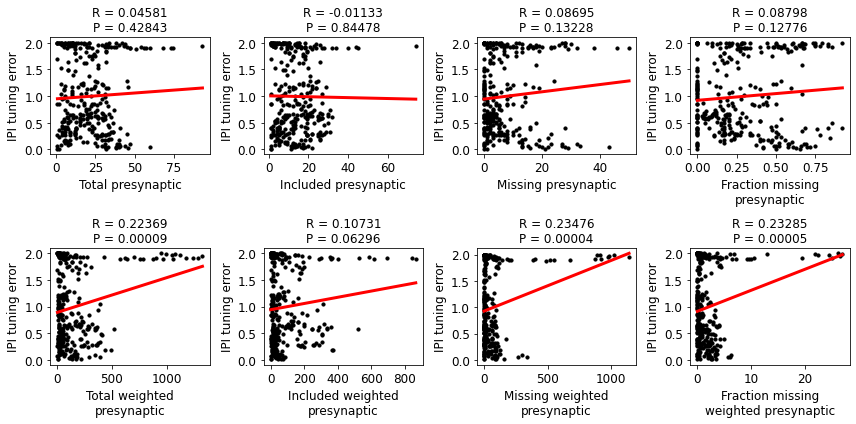

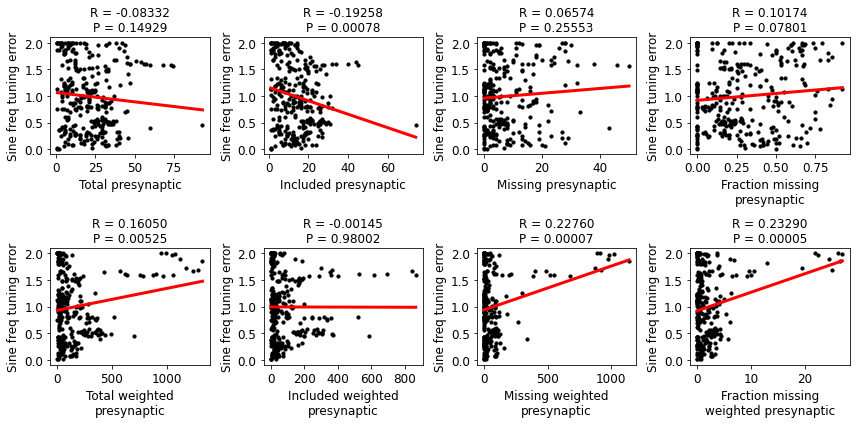

In [24]:
from disp import get_line

for k_err, v_err in err_dict.items():
    
    fig, axs = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)
    for ctr, (k, v) in enumerate(factor_dict.items()):
        
        y = v_err
        
        ax = axs.flatten()[ctr]
        ax.scatter(v, v_err, s=10, c='k')
        
        x, y, (slp, icpt, r, p, stderr) = get_line(v, y)
        
        ax.plot(x, y, c='r', lw=3)
        
        ax.set_xlabel(k)
        ax.set_ylabel(k_err)
        ax.set_title(f'R = {r:.5f}\nP = {p:.5f}')
        
        set_font_size(ax, 12)
        
        
    if k_err == 'IPI tuning error':
        fig.savefig('plots/cb_ms/ipi_tuning_error_predictors.svg')
    else:
        fig.savefig('plots/cb_ms/freq_tuning_error_predictors.svg')